In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize']=10,6
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import math

2024-05-20 11:49:21.267229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 11:49:21.267401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 11:49:21.421999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check data in input directory after linking dataset
import os
print(os.listdir("../input/rainfall-in-india"))

['rainfall in india 1901-2015.csv', 'district wise rainfall normal.csv']


In [3]:
rainfall_data=pd.read_csv("../input/rainfall-in-india/rainfall in india 1901-2015.csv",encoding = "ISO-8859-1")
rainfall_data.dtypes
df=rainfall_data

In [4]:
# Find coulmns with missing data in data frames
def coulmn_with_missing_valies(df):
    columns_with_missing_values = [col for col in df.columns if df[col].isnull().any()]
    #print(columns_with_missing_values)
    return columns_with_missing_values

In [5]:
# print(coulmn_with_missing_valies(rainfall_data))
df.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
4111    False
4112    False
4113    False
4114    False
4115    False
Length: 4116, dtype: bool

In [6]:
rainfall_data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [7]:
rainfall_data.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,4116.000000,4112.000000,4113.000000,4110.000000,4112.000000,4113.000000,4111.000000,4109.000000,4112.000000,4110.000000,4109.000000,4105.000000,4106.000000,4090.000000,4110.000000,4107.000000,4106.000000,4103.000000
mean,1958.218659,18.957320,21.805325,27.359197,43.127432,85.745417,230.234444,347.214334,290.263497,197.361922,95.507009,39.866163,18.870580,1411.008900,40.747786,155.901753,1064.724769,154.100487
std,33.140898,33.585371,35.909488,46.959424,67.831168,123.234904,234.710758,269.539667,188.770477,135.408345,99.519134,68.685410,42.369611,903.846565,59.308277,201.316965,707.741531,166.942660
min,1901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,62.300000,0.000000,0.000000,57.400000,0.000000
25%,1930.000000,0.600000,0.600000,1.000000,3.000000,8.600000,70.350000,175.600000,155.975000,100.525000,14.600000,0.700000,0.100000,804.500000,4.100000,24.050000,573.850000,34.200000
50%,1958.000000,6.000000,6.700000,7.800000,15.700000,36.600000,138.700000,284.800000,259.400000,173.900000,65.200000,9.500000,3.000000,1121.300000,19.200000,74.800000,881.100000,98.200000
75%,1987.000000,22.200000,26.800000,31.300000,49.950000,97.200000,305.150000,418.400000,377.800000,265.800000,148.400000,46.100000,17.500000,1644.775000,50.375000,196.950000,1288.175000,213.500000
max,2015.000000,583.700000,403.500000,605.600000,595.100000,1168.600000,1609.900000,2362.800000,1664.600000,1222.000000,948.300000,648.900000,617.500000,6331.100000,699.500000,1745.800000,4536.900000,1252.500000


In [8]:
rainfall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4112 non-null   float64
 3   FEB          4113 non-null   float64
 4   MAR          4110 non-null   float64
 5   APR          4112 non-null   float64
 6   MAY          4113 non-null   float64
 7   JUN          4111 non-null   float64
 8   JUL          4109 non-null   float64
 9   AUG          4112 non-null   float64
 10  SEP          4110 non-null   float64
 11  OCT          4109 non-null   float64
 12  NOV          4105 non-null   float64
 13  DEC          4106 non-null   float64
 14  ANNUAL       4090 non-null   float64
 15  Jan-Feb      4110 non-null   float64
 16  Mar-May      4107 non-null   float64
 17  Jun-Sep      4106 non-null   float64
 18  Oct-Dec      4103 non-null   float64
dtypes: flo

In [9]:
dataset=rainfall_data
groups = dataset.groupby('SUBDIVISION')[['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','NOV','DEC']]
data=groups.get_group(('BIHAR'))
data.head()



,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,NOV,DEC
897,1901,51.8,19.6,11.9,1.1,65.6,66.3,245.9,319.4,155.1,7.3,0.1
898,1902,4.6,0.7,24.3,17.3,66.3,118.2,361.0,225.5,358.7,1.1,0.0
899,1903,5.3,4.7,2.0,4.7,28.2,192.9,115.0,342.6,173.9,0.1,0.0
900,1904,6.3,1.7,3.5,5.3,118.7,191.6,394.4,351.3,84.4,10.6,3.8
901,1905,16.0,30.1,32.6,21.4,77.5,50.5,409.1,495.3,353.9,0.0,0.6


In [10]:
# Check all sub divisions
dataset.SUBDIVISION.unique()

array(['ANDAMAN & NICOBAR ISLANDS', 'ARUNACHAL PRADESH',
       'ASSAM & MEGHALAYA', 'NAGA MANI MIZO TRIPURA',
       'SUB HIMALAYAN WEST BENGAL & SIKKIM', 'GANGETIC WEST BENGAL',
       'ORISSA', 'JHARKHAND', 'BIHAR', 'EAST UTTAR PRADESH',
       'WEST UTTAR PRADESH', 'UTTARAKHAND', 'HARYANA DELHI & CHANDIGARH',
       'PUNJAB', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'WEST RAJASTHAN',
       'EAST RAJASTHAN', 'WEST MADHYA PRADESH', 'EAST MADHYA PRADESH',
       'GUJARAT REGION', 'SAURASHTRA & KUTCH', 'KONKAN & GOA',
       'MADHYA MAHARASHTRA', 'MATATHWADA', 'VIDARBHA', 'CHHATTISGARH',
       'COASTAL ANDHRA PRADESH', 'TELANGANA', 'RAYALSEEMA', 'TAMIL NADU',
       'COASTAL KARNATAKA', 'NORTH INTERIOR KARNATAKA',
       'SOUTH INTERIOR KARNATAKA', 'KERALA', 'LAKSHADWEEP'], dtype=object)

In [11]:
data=data.melt(['YEAR']).reset_index()
data.head()

,index,YEAR,variable,value
0,0,1901,JAN,51.8
1,1,1902,JAN,4.6
2,2,1903,JAN,5.3
3,3,1904,JAN,6.3
4,4,1905,JAN,16.0


In [12]:
df= data[['YEAR','variable','value']].reset_index().sort_values(by=['YEAR','index'])
df.head()

,index,YEAR,variable,value
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [13]:
df.columns=['INDEX','YEAR','Month','avg_rainfall']
df.head()


,INDEX,YEAR,Month,avg_rainfall
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [14]:
d={'JAN':1,'FEB':2,'MAR' :3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,
   'OCT':10,'NOV':11,'DEC':12}
df['Month']=df['Month'].map(d)
df.head(12)

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,1,51.8
115,115,1901,2,19.6
230,230,1901,3,11.9
345,345,1901,4,1.1
460,460,1901,5,65.6
575,575,1901,6,66.3
690,690,1901,7,245.9
805,805,1901,8,319.4
920,920,1901,9,155.1
1035,1035,1901,11,7.3


In [15]:
df['Date']=pd.to_datetime(df.assign(Day=1).loc[:,['YEAR','Month','Day']])
df.head(12)

,INDEX,YEAR,Month,avg_rainfall,Date
0,0,1901,1,51.8,1901-01-01
115,115,1901,2,19.6,1901-02-01
230,230,1901,3,11.9,1901-03-01
345,345,1901,4,1.1,1901-04-01
460,460,1901,5,65.6,1901-05-01
575,575,1901,6,66.3,1901-06-01
690,690,1901,7,245.9,1901-07-01
805,805,1901,8,319.4,1901-08-01
920,920,1901,9,155.1,1901-09-01
1035,1035,1901,11,7.3,1901-11-01


In [16]:
cols=['avg_rainfall']
dataset=df[cols]
dataset.head()

,avg_rainfall
0,51.8
115,19.6
230,11.9
345,1.1
460,65.6


In [17]:
series=dataset
series.head()

,avg_rainfall
0,51.8
115,19.6
230,11.9
345,1.1
460,65.6


In [18]:
series.shape


(1265, 1)

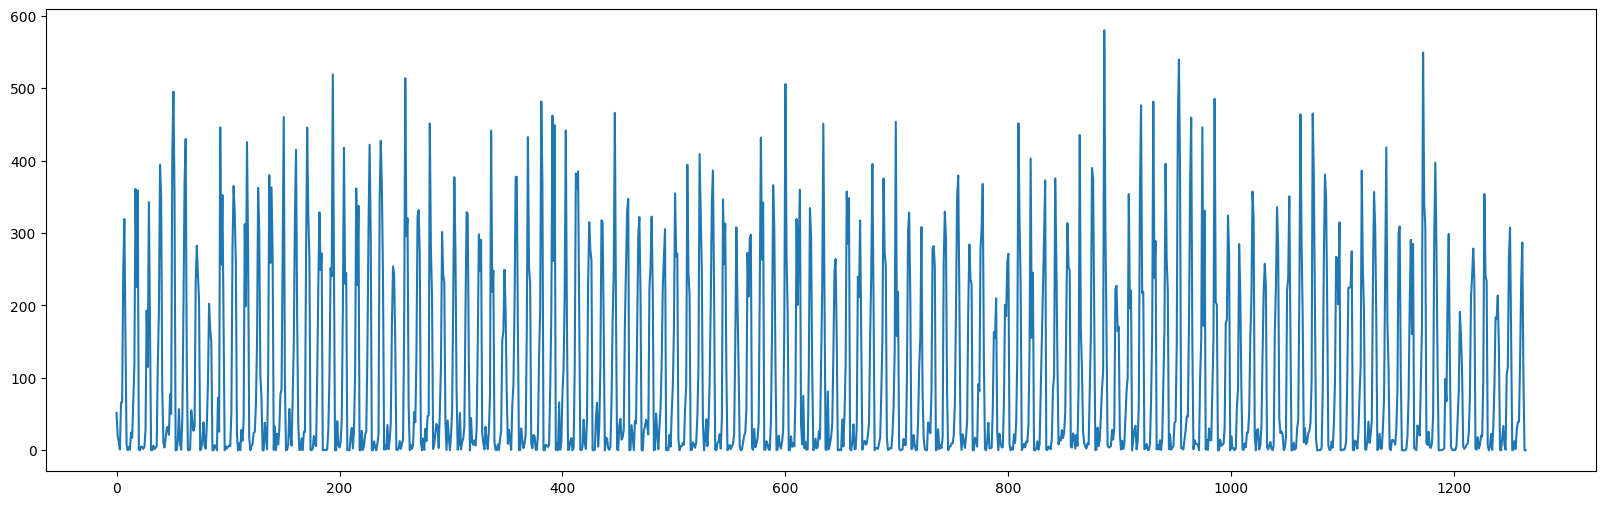

In [19]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

In [20]:
# Get the raw data values from the pandas data frame.
data_raw = series.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.08929496],
       [0.03378728],
       [0.02051371],
       [0.00189622],
       [0.11308396]], dtype=float32)

In [21]:
# Using 80% of data for training, 20% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1012, 253)


In [22]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [23]:
# Create test and training sets
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1010, 1)
New training data shape:
(1010, 1, 1)


In [24]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(2000,activation = 'tanh', recurrent_activation = 'hard_sigmoid', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 64, 
              )
    
    return(model)



In [25]:
# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - loss: 0.0470
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.0415
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - loss: 0.0320
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.0366
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.0369
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0355
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - loss: 0.0363
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - loss: 0.0373
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - loss: 0.0363
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 0.0399


In [26]:
# Predict
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training data score: 108.11 RMSE
Test data score: 94.78 RMSE


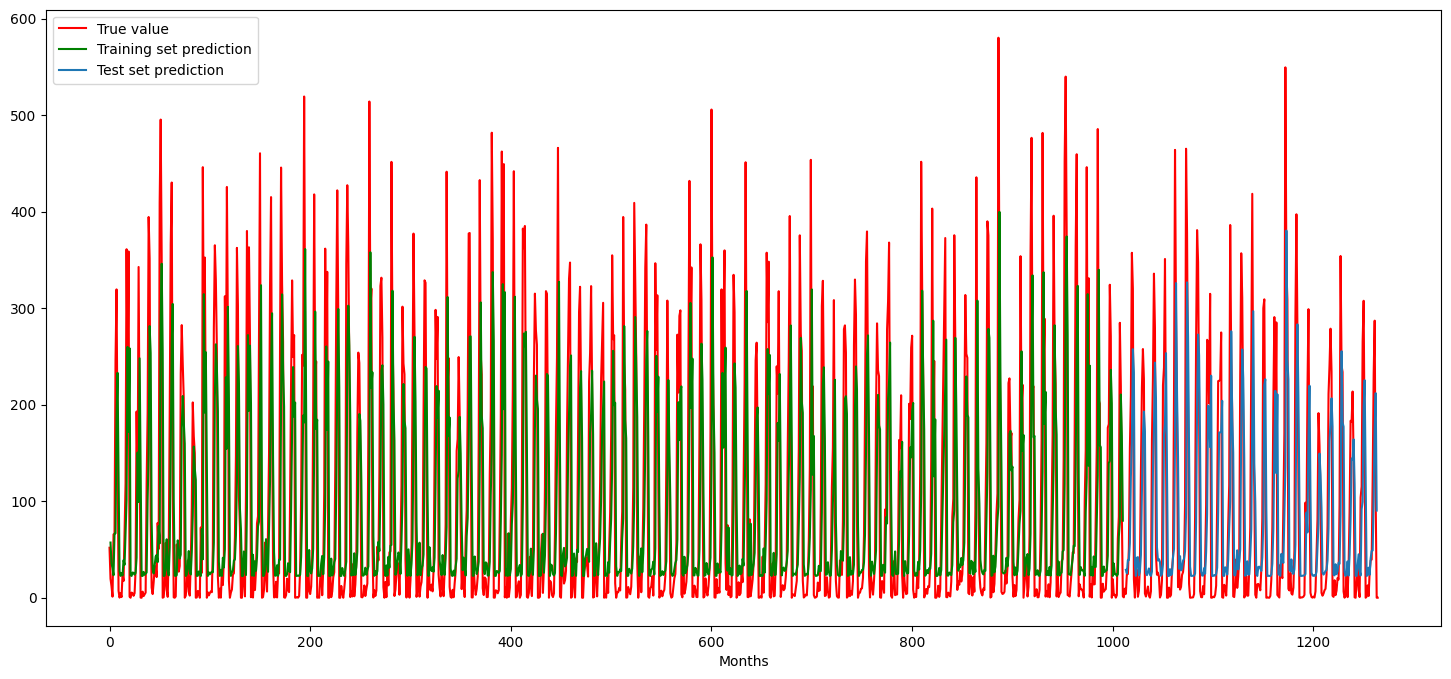

In [27]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (18, 8))
plt.plot(scaler.inverse_transform(dataset), label = "True value",color='red')
plt.plot(train_predict_plot, label = "Training set prediction",color='green')
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")


plt.legend()
plt.show()

In [28]:
train_predict

array([[ 57.146168],
       [ 35.67531 ],
       [ 30.530886],
       ...,
       [210.48454 ],
       [167.67244 ],
       [ 79.809784]], dtype=float32)